In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from vrc_functions import *

plt.rcParams.update({'font.size': 14})

# Data formating

In [2]:
data = pd.read_csv(r"Z:\TC_Sydney_Uni_research_extract_202410.csv")
data = data[data['ROUTE'] == 'LGHTRL'].reset_index(drop=True)  # Filter by light train
data = data[['ORIGIN_DATE', 'ORIGIN_STOP', 'ORIGIN_STOP_XY',
             'DESTINATION_DATE', 'DESTINATION_STOP', 'DESTINATION_STOP_XY']]  # Filter columns by relevance

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136346 entries, 0 to 136345
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ORIGIN_DATE          136346 non-null  object
 1   ORIGIN_STOP          136346 non-null  object
 2   ORIGIN_STOP_XY       136346 non-null  object
 3   DESTINATION_DATE     136346 non-null  object
 4   DESTINATION_STOP     136346 non-null  object
 5   DESTINATION_STOP_XY  136346 non-null  object
dtypes: object(6)
memory usage: 6.2+ MB


In [3]:
# Delete the distinction between platforms in the origin and destination

def remove_platform(text):
    if 'Platform' in text:
        return text.split('Platform')[0].strip()
    return text

data['ORIGIN_STOP'] = data['ORIGIN_STOP'].map(remove_platform)
data['DESTINATION_STOP'] = data['DESTINATION_STOP'].map(remove_platform)

# Change the stops for an ID
stops_id = {'8100: Gungahlin Place': 0,
            '8101: Gungahlin Place': 0,
            '8104: Manning Clark Crescent': 1,
            '8105: Manning Clark Crescent': 1,
            '8106: Mapleton Avenue': 2,
            '8107: Mapleton Avenue': 2,
            '8108: Nullarbor Avenue': 3,
            '8109: Nullarbor Avenue': 3,
            '8110: Well Station Drive': 4,
            '8111: Well Station Drive': 4,
            '8114: EPIC and Racecourse': 5,
            '8116: Phillip Avenue': 6,
            '8117: Phillip Avenue': 6,
            '8118: Swinden Street': 7,
            '8119: Swinden Street': 7,
            '8120: Dickson': 8,
            '8121: Dickson': 8,
            '8122: Macarthur Avenue': 9,
            '8123: Macarthur Avenue': 9,
            '8124: Ipima Street': 10,
            '8125: Ipima Street': 10,
            '8126: Elouera Street': 11,
            '8127: Elouera Street': 11,
            '8128: Alinga Street': 12,
            '8129: Alinga Street': 12
            }

data['ORIGIN_STOP'] = data['ORIGIN_STOP'].replace(stops_id)
data['DESTINATION_STOP'] = data['DESTINATION_STOP'].replace(stops_id)

# Average demand between 7am and 8am
minimal_time = 8
maximal_time = 9

# Selected date
selected_date = pd.to_datetime('2024-09-18').date()

# To datetime
data['ORIGIN_DATE'] = pd.to_datetime(data['ORIGIN_DATE'], format='%Y-%m-%d %H:%M:%S')
data['DESTINATION_DATE'] = pd.to_datetime(data['DESTINATION_DATE'], format='%Y-%m-%d %H:%M:%S')
# Calculate only the time
data['ORIGIN_TIME'] = data['ORIGIN_DATE'].dt.hour * 60 + data['ORIGIN_DATE'].dt.minute
data['DESTINATION_TIME'] = data['DESTINATION_DATE'].dt.hour * 60 + data['DESTINATION_DATE'].dt.minute
# Filter by date
data['ORIGIN_DATE_DATE'] = data['ORIGIN_DATE'].dt.date
data = data[data['ORIGIN_DATE_DATE'] == selected_date]
# Filter by time
data = data[(data['ORIGIN_TIME'] >= minimal_time*60) & (data['ORIGIN_TIME'] < maximal_time*60)]
# Group demand
demand = data.groupby(['ORIGIN_STOP', 'DESTINATION_STOP']).size().reset_index(name='DEMAND')

# Give the origin-destination matrix shape
demand = demand.pivot(columns='DESTINATION_STOP', index='ORIGIN_STOP', values='DEMAND')
# Make the diagonal zero
for i in range(demand.shape[0]):
    demand.loc[i,i] = 0
# Fill with zero
demand.fillna(0, inplace=True)
# Sort columns
demand = demand[sorted(demand.columns)]

demand

DESTINATION_STOP,0,1,2,3,4,5,6,7,8,9,10,11,12
ORIGIN_STOP,,,,,,,,,,,,,
0,0.0,1.0,10.0,41.0,4.0,0.0,4.0,9.0,84.0,5.0,15.0,21.0,394.0
1,9.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,14.0,0.0,2.0,8.0,49.0
2,34.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,32.0,3.0,9.0,4.0,115.0
3,19.0,0.0,0.0,0.0,3.0,0.0,2.0,1.0,14.0,5.0,1.0,10.0,92.0
4,8.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,14.0,0.0,4.0,4.0,102.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,15.0
6,4.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,4.0,1.0,2.0,1.0,56.0
7,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,64.0
8,16.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,3.0,5.0,14.0,204.0


In [4]:
# To fabricate the travel times with google maps
travel_time = np.zeros((13,13))
travel_time[0,1] = 2
travel_time[1,2] = 1
travel_time[2,3] = 2
travel_time[3,4] = 2
travel_time[4,5] = 4
travel_time[5,6] = 2
travel_time[6,7] = 2
travel_time[7,8] = 2
travel_time[8,9] = 2
travel_time[9,10] = 2
travel_time[10,11] = 1
travel_time[11,12] = 2

for i in range(13):
    for j in range(i+1, 13):
        travel_time[i,j] = travel_time[i,j-1] + travel_time[j-1,j]
        travel_time[j,i] = travel_time[i,j]

travel_time = pd.DataFrame(travel_time)
# Minute to hour
travel_time = travel_time/60
travel_time

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.000000,0.033333,0.050000,0.083333,0.116667,0.183333,0.216667,0.250000,0.283333,0.316667,0.350000,0.366667,0.400000
1,0.033333,0.000000,0.016667,0.050000,0.083333,0.150000,0.183333,0.216667,0.250000,0.283333,0.316667,0.333333,0.366667
2,0.050000,0.016667,0.000000,0.033333,0.066667,0.133333,0.166667,0.200000,0.233333,0.266667,0.300000,0.316667,0.350000
3,0.083333,0.050000,0.033333,0.000000,0.033333,0.100000,0.133333,0.166667,0.200000,0.233333,0.266667,0.283333,0.316667
4,0.116667,0.083333,0.066667,0.033333,0.000000,0.066667,0.100000,0.133333,0.166667,0.200000,0.233333,0.250000,0.283333
5,0.183333,0.150000,0.133333,0.100000,0.066667,0.000000,0.033333,0.066667,0.100000,0.133333,0.166667,0.183333,0.216667
6,0.216667,0.183333,0.166667,0.133333,0.100000,0.033333,0.000000,0.033333,0.066667,0.100000,0.133333,0.150000,0.183333
7,0.250000,0.216667,0.200000,0.166667,0.133333,0.066667,0.033333,0.000000,0.033333,0.066667,0.100000,0.116667,0.150000
8,0.283333,0.250000,0.233333,0.200000,0.166667,0.100000,0.066667,0.033333,0.000000,0.033333,0.066667,0.083333,0.116667
9,0.316667,0.283333,0.266667,0.233333,0.200000,0.133333,0.100000,0.066667,0.033333,0.000000,0.033333,0.050000,0.083333


## Demand plot

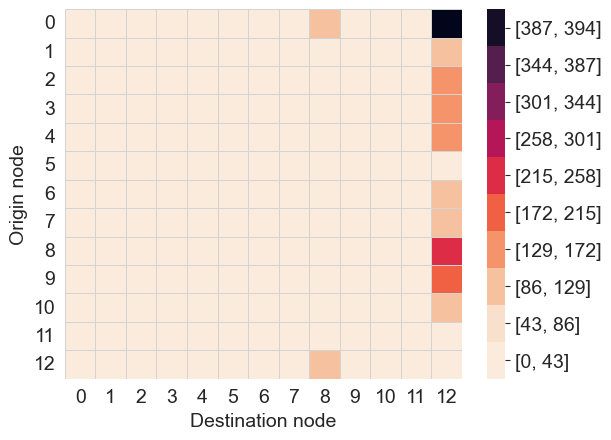

In [5]:
# Pasar la demanda a intervalos
data = demand.values.flatten()
deciles = np.arange(0, max(data), max(data)//9)

def assign_category(x):
    for index, item in enumerate(deciles):
        if x < item:
            return index-1
    return len(deciles)-1

demand_grouped = demand.map(assign_category)

ax = sns.heatmap(demand_grouped, linewidths=.5, linecolor='lightgray', cbar_kws={"boundaries": [-0.5, 0,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5, 9.5]}, cmap='rocket_r')
# Manually specify colorbar labelling after it's been generated
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.25, 0.25, 1, 2, 3, 4, 5, 6, 7, 8.5])
colorbar.set_ticklabels([f'[{int(deciles[i])}, {int(deciles[i+1])}]' for i in range(len(deciles)-1)] + [f'[{int(deciles[-1])}, {int(demand.max().max())}]'])

# X - Y axis labels
ax.set_ylabel('Origin node')
ax.set_xlabel('Destination node')

# Only y-axis labels need their rotation set, x-axis labels already have a rotation of 0
_, labels = plt.yticks()
plt.setp(labels, rotation=0)
# plt.title('Origin-destination matrix Canberra')

plt.savefig('OD Canberra.png', dpi=300)
plt.show()

# Numerical calculations

In [6]:
c0 = 8.61
c1 = 0.3
piv = 2.74
pw = 5.48
pr = 16*piv / 60
t = 0.0416 / 60

plt.rcdefaults()
plt.rcParams.update({'font.size': 14})

In [7]:
# DI values per stop
di_values = di_calculation(demand=demand,
                           travel_time=travel_time,
                           d1=0.9,
                           d2=0.08)

# City fixed cost
vrc_fix_cost = vrc_fix(demand=demand,
                       travel_time=travel_time,
                       piv=piv,
                       board_alight_time=t,
                       c0=c0,
                       c1=c1)

# Optimal VRC and frequencies per divisions
vrc_optimal_divisions = []
freq_optimal_divisions = []
for i in range(1, len(demand.index)-1):
    fo, vo  = vrc_optimization(demand=demand,
                                  travel_time=travel_time,
                                  divided_nodes=[i],
                                  piv=piv,
                                  pw=pw,
                                  pr=pr,
                                  board_alight_time=t,
                                  c0=c0,
                                  c1=c1)
    vrc_optimal_divisions.append(vo)
    freq_optimal_divisions.append(fo)

# Optimal complete line
freq_optimal_complete, vrc_optimal_complete = vrc_optimization(demand=demand,
                                                                travel_time=travel_time,
                                                                divided_nodes=[],
                                                                piv=piv,
                                                                pw=pw,
                                                                pr=pr,
                                                                board_alight_time=t,
                                                                c0=c0,
                                                                c1=c1)

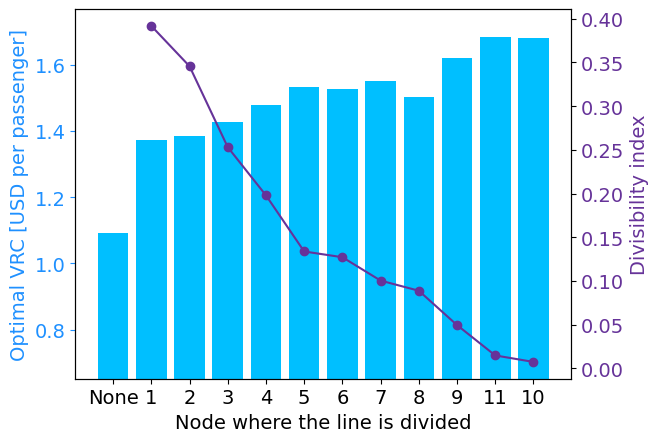

In [8]:
# Datos de ejemplo
total_demand = demand.values.sum()
categories = [f'{i}' for i in range(1, len(demand.index)-1)]
values = vrc_optimal_divisions

# Ordenar los datos por valor en orden ascendente
sorted_data = sorted(zip(categories, values, di_values[1:-1]), key=lambda x: x[2], reverse=True)
categories, values, di_values_sorted = zip(*sorted_data)
# Agregar estructura sin divisiones
categories = ['None'] + list(categories)
values = [vrc_optimal_complete] + list(values)
values = values/total_demand

# Crear gráfico de barras
fig, ax1 = plt.subplots()
ax1.bar(categories, values, color='deepskyblue')

# Añadir título y etiquetas
ax1.set_xlabel('Node where the line is divided')
# dodgerblue
ax1.set_ylabel('Optimal VRC [USD per passenger]', color='dodgerblue')
ax1.set_ylim(bottom=vrc_fix_cost/total_demand)
ax1.tick_params(axis='y', colors='dodgerblue')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(categories[1:], di_values_sorted, color='rebeccapurple', marker='o')
ax2.set_ylabel('Divisibility index', color='rebeccapurple')
ax2.tick_params(axis='y', labelcolor='rebeccapurple')

# Mostrar el gráfico
plt.savefig('Optimal VRC by line structure sorted.png', bbox_inches = 'tight')
plt.show()


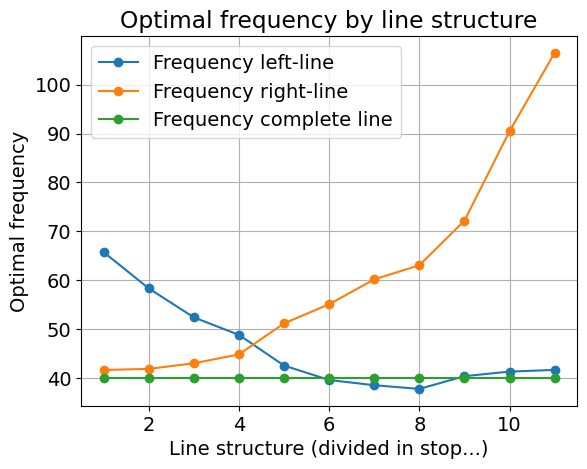

In [9]:
x = [i for i in range(1, len(demand.index)-1)]
freq_optimal_divisions_left = [f[0] for f in freq_optimal_divisions]
freq_optimal_divisions_right = [f[1] for f in freq_optimal_divisions]

fig, ax = plt.subplots()
ax.plot(x, freq_optimal_divisions_left, marker='o', label='Frequency left-line')
ax.plot(x, freq_optimal_divisions_right, marker='o', label='Frequency right-line')
ax.plot(x, [freq_optimal_complete]*len(x), marker='o', label='Frequency complete line')

ax.set_xlabel('Line structure (divided in stop...)')
ax.set_ylabel('Optimal frequency')
ax.legend()

plt.title('Optimal frequency by line structure')
plt.grid()
plt.savefig('Optimal frequency by line structure.png', bbox_inches = 'tight')
plt.show()

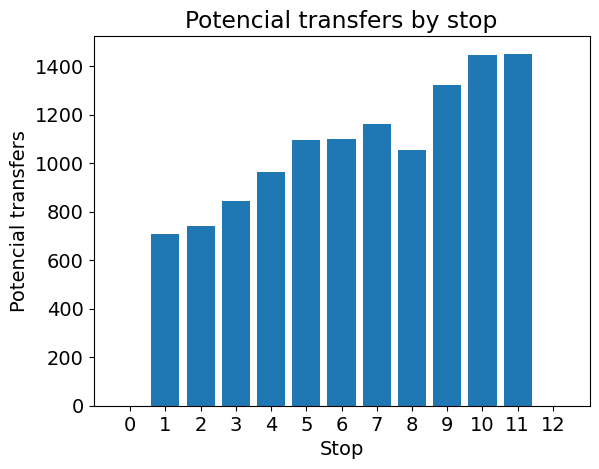

In [12]:
# Calculate transfers
transfers = transfers_calculate(demand=demand)
categories = [i for i in range(len(transfers))]

fig, ax = plt.subplots()
ax.bar(categories, transfers)
ax.set_xlabel('Stop')
ax.set_ylabel('Potencial transfers')

plt.title('Potencial transfers by stop')
plt.xticks(categories)
plt.show()

In [235]:
demand_modified = demand.copy()
factor = 15

# Increase the demand in the line 0 to 8
demand_modified.loc[:8, :8] = demand.loc[:8, :8]*factor
# Increase the alight at 8
demand_modified.loc[:, 8] = demand.loc[:, 8]*factor
# Decrease the transfers at 8
demand_modified.loc[:7, 9:] = demand.loc[:7, 9:]/factor
# Decrease the demand in the line 8 to 12
demand_modified.loc[8:, 8:] = demand.loc[8:, 8:]/factor

normalization_coef = demand.values.sum()/demand_modified.values.sum()
demand_modified = (demand_modified*normalization_coef).round().astype(int)

In [13]:
# Pasar la demanda a intervalos
data = demand_modified.values.flatten()
deciles = np.arange(0, max(data), max(data)//9)

def assign_category(x):
    for index, item in enumerate(deciles):
        if x < item:
            return index-1
    return len(deciles)-1

demand_grouped = demand_modified.map(assign_category)

ax = sns.heatmap(demand_grouped, linewidths=.5, linecolor='lightgray', cbar_kws={"boundaries": [-0.5, 0,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5, 9.5]}, cmap='rocket_r')

# Manually specify colorbar labelling after it's been generated
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.25, 0.25, 1, 2, 3, 4, 5, 6, 7, 8.5])
colorbar.set_ticklabels([f'[{int(deciles[i])}, {int(deciles[i+1])}]' for i in range(len(deciles)-1)] + [f'[{int(deciles[-1])}, {int(demand.max().max())}]'])

# X - Y axis labels
ax.set_ylabel('Origin node')
ax.set_xlabel('Destination node')

# Only y-axis labels need their rotation set, x-axis labels already have a rotation of 0
_, labels = plt.yticks()
plt.setp(labels, rotation=0)
# plt.title('Origin-destination matrix Canberra modified')

plt.savefig('OD Canberra modified.png', dpi=300)
plt.show()


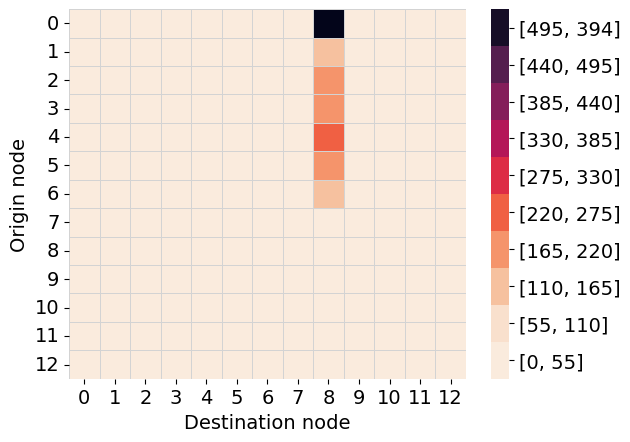

In [14]:
# Figures data

# DI values per stop
di_values = di_calculation(demand=demand_modified,
                           travel_time=travel_time,
                           d1=0.9,
                           d2=0.08)

# City fixed cost
vrc_fix_cost = vrc_fix(demand=demand_modified,
                       travel_time=travel_time,
                       piv=piv,
                       board_alight_time=t,
                       c0=c0,
                       c1=c1)

# Optimal VRC and frequencies per divisions
vrc_optimal_divisions = []
freq_optimal_divisions = []
for i in range(1, len(demand_modified.index)-1):
    fo, vo  = vrc_optimization(demand=demand_modified,
                                  travel_time=travel_time,
                                  divided_nodes=[i],
                                  piv=piv,
                                  pw=pw,
                                  pr=pr,
                                  board_alight_time=t,
                                  c0=c0,
                                  c1=c1)
    vrc_optimal_divisions.append(vo)
    freq_optimal_divisions.append(fo)

# Optimal complete line
freq_optimal_complete, vrc_optimal_complete = vrc_optimization(demand=demand_modified,
                                                                travel_time=travel_time,
                                                                divided_nodes=[],
                                                                piv=piv,
                                                                pw=pw,
                                                                pr=pr,
                                                                board_alight_time=t,
                                                                c0=c0,
                                                                c1=c1)

In [15]:
co_complete = cost_operators(demand=demand_modified,
                               travel_time=travel_time,
                               frequency=[freq_optimal_complete],
                               board_alight_time=t,
                               c0 = c0,
                               c1 = c1,
                               divided_nodes=[])

co_divided_8 = cost_operators(demand=demand_modified,
                               travel_time=travel_time,
                               frequency=freq_optimal_divisions[8],
                               board_alight_time=t,
                               c0 = c0,
                               c1 = c1,
                               divided_nodes=[8])

cu_complete = cost_users(demand=demand_modified,
                           travel_time=travel_time,
                           frequency=[freq_optimal_complete],
                           board_alight_time=t,
                           piv=piv,
                           pw=pw,
                           pr=pr,
                           divided_nodes=[])

cu_divided_8 = cost_users(demand=demand_modified,
                           travel_time=travel_time,
                           frequency=freq_optimal_divisions[8],
                           board_alight_time=t,
                           piv=piv,
                           pw=pw,
                           pr=pr,
                           divided_nodes=[8])

print(f'Operator cost complete: {co_complete}')
print(f'Operator cost divided node 8: {co_divided_8}')
print(f'Users cost complete: {cu_complete}')
print(f'Users cost divided node 8: {cu_divided_8}')
print(f'VRC complete: {co_complete+cu_complete}')
print(f'VRC divided node 8: {co_divided_8+cu_divided_8}')

In [16]:
# Plot

# Datos de ejemplo
categories = ['None'] + [f'{i}' for i in range(1, len(demand_modified.index)-1)]
values = [vrc_optimal_complete] + vrc_optimal_divisions

# Crear gráfico de barras
fig, ax1 = plt.subplots()
ax1.bar(categories, values, color='deepskyblue')

# Añadir título y etiquetas
ax1.set_xlabel('Line structure (divided in stop...)', color='dodgerblue')
ax1.set_ylabel('Optimal VRC')
ax1.set_ylim(bottom=vrc_fix_cost)
ax1.tick_params(axis='y', labelcolor='dodgerblue')


# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(categories[1:], di_values[1:-1], color='rebeccapurple', marker='o', label='DI')
ax2.set_ylabel('Divisibility index', color='rebeccapurple')
ax2.tick_params(axis='y', labelcolor='rebeccapurple')

# Mostrar el gráfico
plt.title('Optimal VRC by line structure')
# plt.savefig('Optimal VRC by line structure modified.png', bbox_inches = 'tight')
plt.show()

Operator cost complete: [592.94126704]
Operator cost divided node 8: [495.28529856]
Users cost complete: [1112.47480277]
Users cost divided node 8: [1190.24313578]
VRC complete: [1705.41606981]
VRC divided node 8: [1685.52843434]


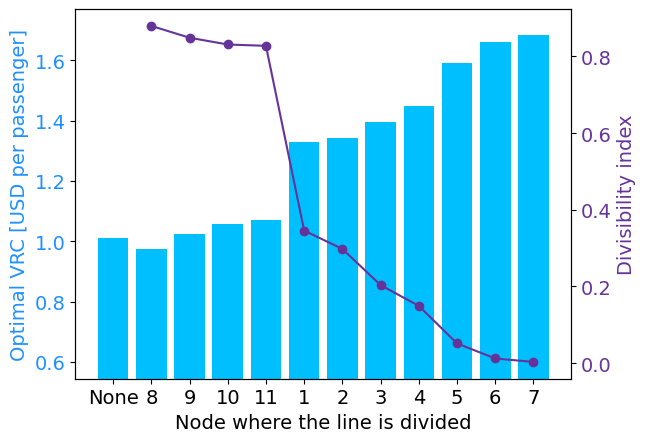